# Treinamento de um modelo para *Image Captioning*
### SCC0287 - Mineração de Dados Não-Estruturados
#### Prof. Ricardo Marcondes Marcacini

Autores:
- Natan Henrique Sanches (11795680)
- Álvaro José Lopes (10873365)

O intuito desse notebook é apresentar a criação de uma pipeline para treinamento de um modelo composto de uma CNN (para processamento da imagem) e um LSTM (para processamento de texto), de forma que esse modelo possa ser utilizado no processo de *Image Captioning*: inferir uma legenda a partir de uma imagem dada.

----

## 0. Preâmbulo

### 0.1. Importação das bibliotecas utilizadas

In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files
from collections import defaultdict
from collections.abc import Iterable as Iterator
from PIL import Image
from typing import Dict, List, TypeVar, Any, TypeAlias, Iterable, Tuple

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

### 0.2. Importação da API do Kaggle para download do *dataset*

Nesse projeto, utilizou-se o *dataset* Flickr8K, contendo 8 mil imagens relacionadas com múltiplas legendas em inglês válidas.

In [4]:
!pip install kaggle

# Upload Kaggle API key to download the datasets
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download "adityajn105/flickr8k"
!unzip -n -q flickr8k.zip
!rm flickr8k.zip

 99% 1.03G/1.04G [00:12<00:00, 104MB/s]
100% 1.04G/1.04G [00:12<00:00, 88.6MB/s]


## 1. Pré-processamento dos dados


### 1.1. Criação dos vetores de *features* a partir das imagens

Nessa parte, utiliza-se uma versão pré-treinada da VGG-16 para permitir a transformação das imagens em descritores, que serão alimentados posteriormente
no LSTM que compõe a *pipeline* completa. As camadas *fully-connected* da VGG foram descartadas por conta de querermos o *embedding* produzido pela rede.

In [6]:
vgg = VGG16()
vgg = Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)
vgg.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Há necessidade, portanto, de produzir os descritores para cada uma das imagens de nosso *dataset*, de forma que possamos utilizá-los para treinar e testar nosso modelo final. Como esse processo é demorado, utilizamos o `pickle` para serializar o dicionário e não precisar sempre regerá-lo.

In [7]:
# Maps {Image Filename} -> {Its feature vector}
image_features = {}
image_dir = "Images"

for img_filename in tqdm(os.listdir(image_dir)):
    path = os.path.join(image_dir, img_filename)

    # Load and reshape the given image
    img = load_img(path, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

    # Preprocess image to feed into VGG and produce its features
    img = preprocess_input(img)
    feature_vec = vgg.predict(img, verbose=0)

    # Store the feature vector into the dictionary
    img_id, _ = os.path.splitext(img_filename)
    image_features[img_id] = feature_vec

pickle.dump(image_features, open("features.pkl", "wb"))
files.download("features.pkl")

  0%|          | 0/8091 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 1.2. Processamento das legendas das imagens

In [8]:
START_TOKEN = "stsq"
END_TOKEN = "endsq"

In [9]:
def preprocess_captions(caption_map: Dict[str, List[str]]):
    for captions in caption_map.values():
        for i, caption in enumerate(captions):
            caption = caption.lower()
            caption = caption.replace(r"[^A-Za-z]", "")
            caption = caption.replace(r"\s+", "")
            caption = " ".join([w for w in caption.split() if len(w) > 1])
            captions[i] = " ".join([START_TOKEN, caption, END_TOKEN])

In [10]:
def load_captions(caption_filename: str) -> Dict[str, List[str]]:
    # Load the file that relates each image with one or more captions
    with open(caption_filename) as f:
        next(f)
        captions = f.read()

    # Maps {Image Filename} -> {List of captions}
    caption_map = defaultdict(list)

    for line in tqdm(captions.split("\n")):
        tokens = line.split(",")
        if len(tokens) < 2:
            continue

        # Split into filename and list of captions
        img_filename, caption = tokens[0], tokens[1:]
        img_id, _ = os.path.splitext(img_filename)
        caption = " ".join(caption)

        # Map the image filename to the caption collection
        caption_map[img_id].append(caption)

    return caption_map

In [11]:
T = TypeVar("T")
NestedIter: TypeAlias = Iterable[T | "NestedIter"]

def flatten_dict(d: Dict[Any, NestedIter]) -> List[T]:
    def _flatten(it: NestedIter) -> List[T]:
        flattened = []
        for el in it:
            if isinstance(el, Iterator) and not isinstance(el, str):
                flattened.extend(_flatten(el))
            else: flattened.append(el)
        return flattened
    return _flatten(d.values())

In [12]:
captions_map = load_captions("captions.txt")
preprocess_captions(captions_map)
all_captions = flatten_dict(captions_map)

  0%|          | 0/40456 [00:00<?, ?it/s]

### 1.3. Tokenização das legendas

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [14]:
vocab_size = len(tokenizer.word_index) + 1
word_max_length = max(len(caption.split()) for caption in all_captions)

### 1.4. Criação dos *datasets* para treino e teste

In [15]:
def train_test_split(
    captions_map: Dict[str, List[str]],
    size: float=0.9
) -> Tuple[List[str], List[str]]:
    """
        Split the given dictionary into train and test lists of image IDs.
        Returns the train and the test lists, respectively.
    """
    img_ids = list(captions_map.keys())
    splitted = int(len(img_ids) * size)
    return img_ids[:splitted], img_ids[splitted:]


In [16]:
train_set, test_set = train_test_split(captions_map, 0.9)

## 2. Treinamento do Modelo

### 2.1. Instanciação do Modelo

O modelo proposto possui duas ramificações: um *Feature Encoder*, para codificação dos *embeddings* das imagens (processado pela CNN) dado como um dos parâmetros de entrada, e um *Sequence Encoder*, que processa sequências textuais utilizando um LSTM.

In [17]:
def create_model(embedding_size: int, word_max_length: int, vocab_size: int) -> Model:
    inputs_emb = Input(shape=(embedding_size,))
    inputs_seq = Input(shape=(word_max_length,))

    # Feature Encoder
    fe1 = Dropout(0.4)(inputs_emb)
    fe = Dense(256, activation="relu")(fe1)

    # Sequence Encoder
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs_seq)
    se2 = Dropout(0.4)(se1)
    se = LSTM(256)(se2)

    # Decoder Model
    decoder1 = add([fe, se])
    decoder2 = Dense(256, activation="relu")(decoder1)
    outputs = Dense(vocab_size, activation="softmax")(decoder2)

    return Model(inputs=[inputs_emb, inputs_seq], outputs=outputs)

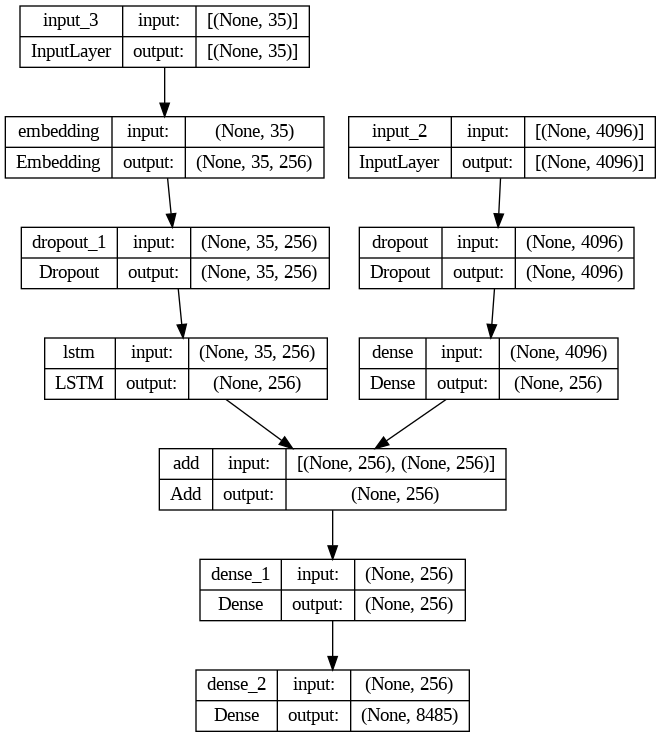

In [18]:
model = create_model(4096, word_max_length, vocab_size)
model.compile(loss="categorical_crossentropy", optimizer="adam")
plot_model(model, show_shapes=True)

### 2.2. Criação do gerador de dados

In [21]:
def data_generator(
    image_names: List[str],
    captions_map: Dict[str, List[str]],
    image_features: Dict[str, List[int]],
    tokenizer: Tokenizer,
    word_max_length: int,
    vocab_size: int,
    batch_size: int
) -> Tuple[List[List[int]], List[str], List[str]]:
    """
        Generator to generate batches from the data in order to train
        and test the model.
    """
    X_emb, X_seq, y = [], [], []
    local_batch_size = 0

    for image_name in image_names:
        local_batch_size += 1
        captions = captions_map[image_name]

        for caption in captions:
            [seq] = tokenizer.texts_to_sequences([caption])

            # Generate all sequences to obtain the final caption
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                [in_seq] = pad_sequences([in_seq], maxlen=word_max_length)
                [out_seq] = to_categorical([out_seq], num_classes=vocab_size)

                [feature_vec] = image_features[image_name]
                X_emb.append(feature_vec)
                X_seq.append(in_seq)
                y.append(out_seq)

        # If the batch size is achieved, yield the result
        if local_batch_size == batch_size:
            X_emb, X_seq, y = np.array(X_emb), np.array(X_seq), np.array(y)
            yield [X_emb, X_seq], y
            X_emb, X_seq, y = [], [], []
            local_batch_size = 0

### 2.3. Treinamento

In [22]:
# Load the feature map of each image
with open("features.pkl", "rb") as f:
    image_features = pickle.load(f)

In [23]:
epochs = 25
batch_size = 32
steps = len(train_set) // batch_size

for _ in range(epochs):
    gen = data_generator(train_set, captions_map, image_features,
                         tokenizer, word_max_length, vocab_size, batch_size)
    model.fit(gen, epochs=1, steps_per_epoch=steps, verbose=2)

227/227 - 77s - loss: 5.2098 - 77s/epoch - 340ms/step
227/227 - 66s - loss: 3.9932 - 66s/epoch - 289ms/step
227/227 - 59s - loss: 3.5749 - 59s/epoch - 258ms/step
227/227 - 60s - loss: 3.3145 - 60s/epoch - 266ms/step
227/227 - 60s - loss: 3.1242 - 60s/epoch - 263ms/step
227/227 - 61s - loss: 2.9747 - 61s/epoch - 268ms/step
227/227 - 59s - loss: 2.8523 - 59s/epoch - 261ms/step
227/227 - 61s - loss: 2.7569 - 61s/epoch - 269ms/step
227/227 - 60s - loss: 2.6747 - 60s/epoch - 265ms/step
227/227 - 62s - loss: 2.6060 - 62s/epoch - 273ms/step
227/227 - 59s - loss: 2.5572 - 59s/epoch - 259ms/step
227/227 - 64s - loss: 2.4992 - 64s/epoch - 280ms/step
227/227 - 59s - loss: 2.4468 - 59s/epoch - 260ms/step
227/227 - 62s - loss: 2.4039 - 62s/epoch - 271ms/step
227/227 - 59s - loss: 2.3615 - 59s/epoch - 261ms/step
227/227 - 62s - loss: 2.3162 - 62s/epoch - 272ms/step
227/227 - 61s - loss: 2.2773 - 61s/epoch - 270ms/step
227/227 - 60s - loss: 2.2448 - 60s/epoch - 263ms/step
227/227 - 62s - loss: 2.2161

In [24]:
model.save("model.keras")
files.download("model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Teste do Modelo (Inferência)

In [25]:
model = load_model("model.keras")

In [26]:
def create_map_token_idx_to_word(tokenizer: Tokenizer) -> Dict[int, str]:
    idx_to_word = {}
    for word, index in tokenizer.word_index.items():
        idx_to_word[index] = word
    return idx_to_word

In [27]:
def generate_caption(img_filename: str) -> str:
    img_id, _ = os.path.splitext(img_filename)
    idx_to_word = create_map_token_idx_to_word(tokenizer)

    # Get all features from the target image
    features = image_features[img_id]

    in_text = START_TOKEN
    for _ in range(word_max_length):
        [sequence] = tokenizer.texts_to_sequences([in_text])
        sequence = pad_sequences([sequence], word_max_length)

        # Inference to predict the next word
        yhat = model.predict([features, sequence], verbose=0)
        yhat = np.argmax(yhat)

        # Concatenate the results to get a new sequence
        word = idx_to_word[yhat]
        in_text = " ".join([in_text, word])
        if word == END_TOKEN:
            break

    return in_text.replace(START_TOKEN, "").replace(END_TOKEN, "").strip()

In [28]:
def plot_caption(img_name: str, caption: str):
    path = os.path.join("Images", img_name)
    img = Image.open(path)
    w, h = img.size
    plt.imshow(img)
    plt.axis("off")
    plt.text(0.5*w, 1.05*h, caption, horizontalalignment='center')

### 3.2. Visualização dos Resultados

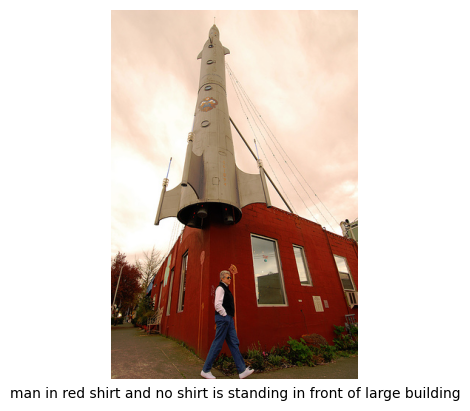

In [36]:
img_name = f"{test_set[0]}.jpg"

caption = generate_caption(img_name)
plot_caption(img_name, caption)

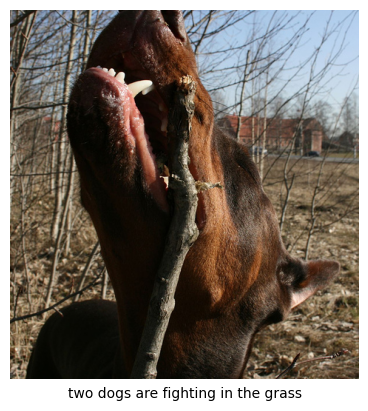

In [37]:
img_name = f"{test_set[1]}.jpg"

caption = generate_caption(img_name)
plot_caption(img_name, caption)

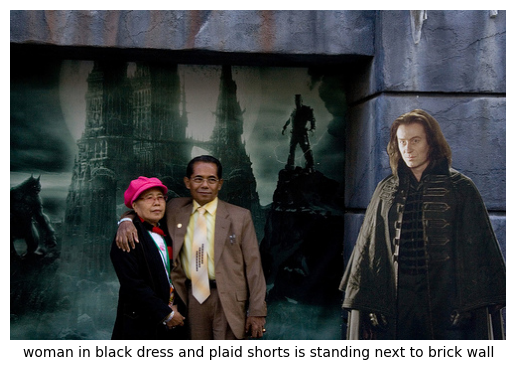

In [38]:
img_name = f"{test_set[2]}.jpg"

caption = generate_caption(img_name)
plot_caption(img_name, caption)